In [51]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import model_selection

In [52]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

### Data import

Data loading - the 'clean' data has datetime index 

In [53]:
df_temp = pd.read_csv(r"C:\Users\macie\OneDrive\Pulpit\Fellowship\999_OTHER\DP_paper\Line_Test1.csv")
df_temp.index = df_temp.apply(lambda row: datetime(year=int(row.Year), month=int(row.Month), day=int(row.Day), hour=int(row.Hour), minute=int(row.Minute)), axis=1)
df_temp.rename(columns={'TEMP_LINE_SM1':'temp'}, inplace=True)
df_temp.ffill(inplace=True)
df_temp_resampled = df_temp.copy()

Data standardization - std. scaling. We pick only the temperature column

In [54]:
df_data = pd.DataFrame(df_temp_resampled.temp)

data_mean = df_data.mean()
data_std = df_data.std()
df_data = (df_data - data_mean) / data_std
len_data = len(df_data)

Data splits - train/val/test

In [55]:
tss = model_selection.TimeSeriesSplit(5)
df_test = df_data[int(0.9*len_data):]
indices = np.arange(0.9*len_data)

### Time window genrator

Window generator -> to be fed into the model. Sets up the time windows for the model.

In [56]:
class TimeWindowGenerator():

    def __init__(self, input_width, output_width=1, output_offset=1, df_train = df_train, df_val=df_val, df_test=df_test, column_name = ['temp']):

        # define the raw datasets
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test

        # Window parameters
        self.input_width = input_width
        self.output_width = output_width
        self.offset = output_offset
        self.total_size = self.input_width + self.offset
        
        # Define the indices
        self.input_indices = np.arange(0, self.input_width)
        self.output_indices = np.arange(self.total_size - self.output_width, self.total_size)
        
    # model representation when called
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.output_indices}'])
    

    def slice(self, batches):
        # For training probably many batches, for test and deployment: one at a time
        if len(np.shape(batches)) == 3:
            inputs = batches[:, slice(0, self.input_width)]
            output = batches[:, slice(self.total_size - self.output_width, self.total_size)]

        else:
            inputs = batches[slice(0, self.input_width)]
            output = batches[slice(self.total_size - self.output_width, self.total_size)]

        # Set shape for the tf dataset - works only if a tf.Dataset object is fed  
        # e.g., a timeseries_dataset_from_array object
        inputs.set_shape([None, self.input_width, None])
        output.set_shape([None, self.output_width, None])

        return inputs, output
    
    def compile_dataset(self, data, opt_shuffle=True):
        # Convert to numpy float32 - for the keras object
        data_array = np.array(data, dtype='float32')
        
        keras_dataset = tf.keras.utils.timeseries_dataset_from_array(
            data = data_array,
            targets=None,
            sequence_length=self.total_size,
            sequence_stride=1,
            shuffle=opt_shuffle,
            batch_size=32
        )

        keras_dataset = keras_dataset.map(self.slice)

        return keras_dataset
    
    @property
    def train(self):
        return self.compile_dataset(self.df_train)

    @property
    def val(self):
        return self.compile_dataset(self.df_val)

    @property
    def test(self):
        return self.compile_dataset(self.df_test, opt_shuffle=False)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

Universal trainer

In [57]:
def tiny_trainer(model, model_name, window_generator, max_epochs):
  cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  # cb_checkpointing = tf.keras.callbacks.ModelCheckpoint(r'models/line_temp_model_{}_10_mins.hdf5'.format(model_name), monitor='val_loss', save_best_only=True, save_weights_only=True)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window_generator.train, epochs=max_epochs,
                      validation_data=window_generator.val,
                      callbacks=[cb_early_stopping], verbose=0)
  return history

### Model definitions

In [58]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [59]:
mlp_model = tf.keras.Sequential([
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    # Reshape into output
    tf.keras.layers.Reshape([-1, 1])
])

### Train

In [67]:
pers_mae = []
test_mae = []

for i, (train_index, val_index) in enumerate(tss.split(indices)):

    df_train = df_data.iloc[train_index]
    df_val = df_data.iloc[val_index]

    window_1 = TimeWindowGenerator(input_width=1, df_train=df_train, df_val=df_val, df_test=df_test, output_offset=1)
    window_6 = TimeWindowGenerator(input_width=6, df_train=df_train, df_val=df_val, df_test=df_test, output_offset=1)

    persistance_model = Baseline(label_index=None)
    history_persitance = tiny_trainer(model=persistance_model, model_name='persistence', window_generator=window_1, max_epochs=100)
    history_mlp = tiny_trainer(model=mlp_model, model_name='cv_test', window_generator=window_6, max_epochs=100)

    pers_mae.append(persistance_model.evaluate(window_1.test)[1])
    test_mae.append(mlp_model.evaluate(window_6.test)[1])

29/29 [==============================] - 0s 4ms/step - loss: 0.0074 - mean_absolute_error: 0.0585


In [68]:
print(f"Model CV score: \n - pers:   {np.average(pers_mae)}\n - test:   {np.average(test_mae)}")

Model CV score: 
 - pers:   0.06187312677502632
 - test:   0.05988349989056587


In [69]:
test_mae

[0.0599004402756691,
 0.06045142933726311,
 0.06000230833888054,
 0.06057581678032875,
 0.058487504720687866]

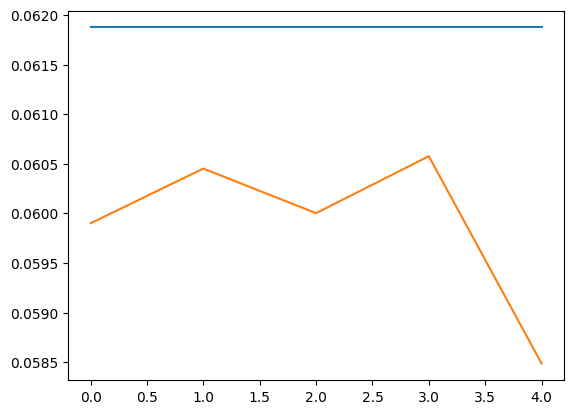

In [70]:
plt.plot(pers_mae, label='pers')
plt.plot(test_mae, label='test')

### Test

In [ ]:
# model_error_val = {}
# model_error_test = {}
# model_FS_test = {}

# print('Test model: persistence')
# model_error_val['persistance'] = persistance_model.evaluate(window_1.val, verbose=1)
# model_error_test['persistance'] = persistance_model.evaluate(window_1.test, verbose=1)



# for name, model in trained_models.items():
#     print(f'Test model: {name}')
#     model_error_val[name] = model.evaluate(window_6.val, verbose=1)
#     model_error_test[name] = model.evaluate(window_6.test, verbose=1)
#     trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
#     model_FS_test[name] = 1- (model_error_test[name][1] / model_error_test["persistance"][1])

#     print(f'Number of parameters: {trainable_params}')
#     print(f'FS_test = {1- (model_error_test[name][1] / model_error_test["persistance"][1]):.3}, FS_val = {1- (model_error_val[name][1] / model_error_val["persistance"][1]):.3}')

In [ ]:
# for key in model_error_test:
#     print(key)
#     print(f'RMSE: {np.sqrt(model_error_test[key][0]):.03f}')
#     print(f'MAE: {model_error_test[key][1]:.03f}')

In [ ]:
# heights_5 = [-0.30703689139926404, -0.01422131780964464, -0.0005217070157221837, -0.018031434759318454, 0.03503366470308544, 0.08436101788320138]
# heights_10 = [-0.04333260114009341, 0.0188142712211391, -0.03838395983071763, -0.03985975506068984, 0.0479286104135771, 0.04025522073999588]
# heights_15 = [-0.04293350995875023, -0.02236810575739101, -0.010567094878774164, 0.00982418708485433, -0.003811709080938863, -0.028289809135001454]

In [ ]:
# plt.figure(figsize=(6, 4))

# plt.grid(visible=True, which='major', alpha=0.2, color='#748c9d')


# x = np.arange(0, 6)
# y = np.arange(-0.35, 0.15, 0.05)
# plt.bar(x-0.3, heights_5, width=0.25, label='5-min', color='#072449')
# plt.bar(x, heights_10, width=0.25, label='10-min', color='#fbd404')
# plt.bar(x+0.3, heights_15, width=0.25, label='15-min', color='#fc0313')


# plt.ylabel('Forecast Skill [%]')
# plt.xticks(ticks=x, labels=['S_2', 'M_2', 'L_2', 'S_3', 'M_3', 'L_3'])
# plt.yticks(ticks=y, labels=[f'{(item*100):.0f}%' for item in y])
# plt.legend(loc='lower right')
# plt.tight_layout()
# plt.savefig(r'img\DLR\results_mlps.png', dpi=300)
# plt.show()

